In [1]:
import os#

from pathlib import Path#

import pandas as pd
import torch
import numpy as np
from stk_search.utils.config_utils import read_config, save_config
from stk_search.utils import config_utils
import datetime
from stk_search.utils import update_datasets
import importlib
importlib.reload(config_utils)

<module 'stk_search.utils.config_utils' from '/media/mohammed/Work/Work/STK_search/src/stk_search/utils/config_utils.py'>

In [2]:
#Helper function to split the dataset
from stk_search.geom3d import polymer_GNN_architecture_utils

def check_building_block_present(df_total_path_new,config_dir):
    df_total = pd.read_csv(df_total_path_new,low_memory=False)
    config = read_config(config_dir)
    bbs_dict = polymer_GNN_architecture_utils.get_bbs_dict(
        config['pymongo_client'] , config['precursor_database_name']
    )
    bbs_dict
    # check df_total has inchikey in bb_dict
    for i in range(6):
        df_total = df_total[df_total[f'InChIKey_{i}'].isin(bbs_dict.keys())]
    df_total.to_csv(df_total_path_new, index=False)
    return df_total

def do_random_split(config,hide_best_molecules=True):
    df_path = Path(
            config["df_total"]
        )
    if os.path.isfile(df_path):
        df = pd.read_csv(df_path,low_memory=False)
    else:
        print("No dataframe found, will resort in a random split from the data in the database")
    def topk_split(topkmol, df,num_molecules_dataset=5000,target_name='target',hide_best_molecules=hide_best_molecules):
        min_target_out_of_database = -np.sort(-df[target_name].values)[topkmol]
        df_test = df[df[target_name]>=min_target_out_of_database]
        if hide_best_molecules:
            df_train = df[df[target_name]<min_target_out_of_database]
        else:
            df_train = df.copy()
            print(df_train.shape[0])
        # add random element from df to the test set
        #df_test_random = df.sample(n=1000, random_state=1)
        #df_test = pd.concat([df_test, df_test_random])
        df_test.reset_index(drop=True, inplace=True)
        list_col = [f'InChIKey_{x}' for x in range(6)]
        list_col.append(target_name)
        list_col.append('InChIKey')
        df_train = df_train[list_col]
        df_train = df_train[~df_train['InChIKey'].isin(df_test['InChIKey'])]
        if num_molecules_dataset>df_train.shape[0]:
            print("Warning: the number of molecules in the dataset is smaller than the number of molecules requested")
            num_molecules_dataset = df_train.shape[0]
        df_train = df_train.sample(num_molecules_dataset)
        df_val = df_train.sample(frac=0.1, random_state=1)
        df_train = df_train[~df_train['InChIKey'].isin(df_val['InChIKey'])]
        df_train.reset_index(drop=True, inplace=True)
        df_val.reset_index(drop=True, inplace=True)
        return df_train, df_val, df_test
    topKmol = int(df.shape[0]*0.01)
    df_train, df_val, df_test = topk_split(topKmol, df,config["num_molecules"],config["target_name"],hide_best_molecules=hide_best_molecules)
    config_dir= config["running_dir"]
    df_train.to_csv(config_dir + "df_train.csv", index=False)
    df_val.to_csv(config_dir + "df_val.csv", index=False)
    df_test.to_csv(config_dir + "df_test.csv", index=False)
    for key in ['df_train','df_val','df_test']:
        check_building_block_present(config_dir + key + ".csv",config_dir)
    return df_train, df_val, df_test



In [3]:
# load the database to learn from
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total = pd.read_csv(df_total_path,low_memory=False)
print(df_total.shape[0])
df_total

30000


,InChIKey,InChIKey_0,InChIKey_1,InChIKey_2,InChIKey_3,InChIKey_4,InChIKey_5,num_BB,_id_x,Host IP_x,...,Excited state energy (eV),Excited state oscillator strength,Host IP_y,cal_folder_y,ES1,fosc1,target,2d_tani_pca_1,2d_tani_pca_2,PCA1
0,CLUOOVKTWZALSH-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,6.0,64d3e7f254f281add0b79e3b,129.31.64.208,...,"[3.994, 4.042, 4.08, 4.086, 4.117, 4.135, 4.53...","[0.1243, 0.153, 1.1697, 0.0908, 0.0574, 0.225,...",129.31.64.208,/media/storage-jelfscompute4/ma11115/Database_...,3.994,0.1243,-2.507029,-1.481492,-0.711649,-1.481492
1,FIAQXLPLTBETIQ-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,DNHRBCFMFYOUKM-UHFFFAOYSA-N,6.0,64d2671054f281add0ab9f7d,unknown,...,"[3.97, 3.993, 4.033, 4.048, 4.1, 4.468, 4.493,...","[0.1121, 0.7001, 0.151, 0.2114, 0.4041, 0.0137...",NaN,NaN,3.970,0.1121,-2.572794,-1.426185,-0.714994,-1.426185
2,BPPOMYWNHKZIDY-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,6.0,64d3d12454f281add0b6e27c,129.31.64.208,...,"[3.309, 3.524, 3.539, 3.801, 3.968, 4.022, 4.0...","[0.0925, 0.0002, 0.0114, 0.0521, 0.0396, 0.962...",129.31.64.208,/media/storage-jelfscompute4/ma11115/Database_...,3.309,0.0925,-2.049258,-1.211625,-0.677382,-1.211625
3,VHLADBSIMMJWOE-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,6.0,64d34e7654f281add0abce29,unknown,...,"[3.415, 3.456, 3.562, 3.583, 3.615, 3.646, 3.6...","[0.0005, 0.0009, 0.0036, 0.0078, 0.0043, 0.011...",NaN,NaN,3.415,0.0005,-4.742130,-0.877781,-1.337407,-0.877781
4,DUPCULAXVLTLBX-UHFFFAOYSA-N,GKKUHQQNQBVLSW-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,PNLCAIFEPYYUCC-UHFFFAOYSA-N,UANFRSYASSMVLC-UHFFFAOYSA-N,DNHRBCFMFYOUKM-UHFFFAOYSA-N,6.0,64d34ec654f281add0abcfc5,unknown,...,"[2.841, 3.339, 3.483, 3.544, 3.685, 3.857, 3.8...","[0.3302, 0.0721, 0.0038, 0.0144, 0.2322, 0.102...",NaN,NaN,2.841,0.3302,-1.628323,-1.224275,-0.606765,-1.224275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,QPAOJQBFDLENRA-UHFFFAOYSA-N,OHCHMBZKZQHAPX-UHFFFAOYSA-N,AJKFTLSGAAURDT-UHFFFAOYSA-N,APDAUBNBDJUQGW-UHFFFAOYSA-N,VEGYYSITGMCNND-UHFFFAOYSA-N,KEPNBEPTGHROGD-UHFFFAOYSA-N,QEAXUGGYBUGDHX-UHFFFAOYSA-N,NaN,660dd8681474e31c4d04df01,cx1,...,"[2.569, 3.161, 3.556, 3.595, 3.763, 3.898, 3.9...","[6.0565, 0.5794, 0.0153, 0.0143, 0.0154, 0.007...",cx1,/rds/general/ephemeral/user/ma11115/ephemeral/...,2.569,6.0565,0.083022,NaN,NaN,NaN
29996,HFBVCLZUBWRVGF-LTKUFQEZSA-N,ZYFAZQDJDGUYES-UHFFFAOYSA-N,NMTVJRGZIBKXSL-AOOOYVTPSA-N,YYTSOZXMJUHWJS-UHFFFAOYSA-N,VEGYYSITGMCNND-UHFFFAOYSA-N,VQAFMTSSCUETHA-UHFFFAOYSA-N,ZYFAZQDJDGUYES-UHFFFAOYSA-N,NaN,6603c3f71474e31c4d1bf9fb,cx1,...,"[2.794, 2.955, 3.317, 3.354, 3.566, 3.626, 3.6...","[0.2265, 5.7068, 1.2005, 0.1716, 0.0719, 0.063...",cx1,/rds/general/ephemeral/user/ma11115/ephemeral/...,2.794,0.2265,-1.313232,NaN,NaN,NaN
29997,BXODPCSZUFLJMI-UHFFFAOYSA-N,WZTRBPPIJBTTOH-UHFFFAOYSA-N,CGQMQIAGYJZKNI-UHFFFAOYSA-N,ZQUFQULVODWNAL-UHFFFAOYSA-N,VEGYYSITGMCNND-UHFFFAOYSA-N,KEPNBEPTGHROGD-UHFFFAOYSA-N,IEJYOBZZFZTJMY-UHFFFAOYSA-N,NaN,660c3bb51474e31c4dfc3f26,cx1,...,"[2.713, 3.582, 3.839, 3.875, 3.897, 3.975, 4.0...","[4.231, 0.1972, 0.151, 0.037, 0.0374, 0.0061, ...",cx1,/rds/general/ephemeral/user/ma11115/ephemeral/...,2.713,4.2310,0.027243,NaN,NaN,NaN
29998,QJPYFPUQUYRJRW-UHFFFAOYSA-N,MSUPZGGVRIRXAI-UHFFFAOYSA-N,APDAUBNBDJUQGW-UHFFFAOYSA-N,RJNSNLQCGHZNCC-UHFFFAOYSA-N,APDAUBNBDJUQGW-UHFFFAOYSA-N,AJKFTLSGAAURDT-UHFFFAOYSA-N,OHCHMBZKZQHAPX-UHFFFAOYSA-N,NaN,660e3ebd1474e31c4d22786c,cx1,...

In [4]:

importlib.reload(update_datasets)
importlib.reload(config_utils)
config_dir_list = []
pymongo_client = "mongodb://localhost:27017/"
for num_molecules in [5000]:
    config = config_utils.generate_config(
        num_molecules=num_molecules, df_path=df_total_path, max_epochs=200,
        target_name = 'target', 
        running_dir = f"data_example/representation_learning/",
    )
    config['pymongo_client'] = pymongo_client
    config['precursor_database_name'] = 'stk_mohammed_precursor'
    config['database_name'] = 'stk_constructed'
    config['df_precursor'] = "data_example/precursor/df_properties.pkl"
    config["ephemeral_path"] = "data_example/representation_learning/ephemeral/Random_split/"
    config['max_epochs'] = 10
    config['precursor_database_name'] = "stk_precursor"
    config_dir= config["running_dir"]
    save_config(config,config_dir)
    if config["split_type"] == "rand":
        df_train, df_val, df_test = do_random_split(config,hide_best_molecules=True)
    
    config_dir_list.append(config_dir)

In [1]:
import swifter


In [6]:
#test script
import swifter
config_dir =  config_dir_list[0]
dev_scripts_dir = "/media/mohammed/Work/Work/STK_search/src/dev_scripts/"
%run {dev_scripts_dir}/run_representation_learning_polymer.py --config_dir {config_dir}


Empty DataFrame
Columns: [InChIKey_0, InChIKey_1, InChIKey_2, InChIKey_3, InChIKey_4, InChIKey_5, target, InChIKey]
Index: []


ValueError: Cannot set a DataFrame with multiple columns to the single column polymer

In [7]:

# run model training including all data
name = "new_representation_different_embedding"
os.chdir('/rds/general/user/ma11115/home/STK_Search/STK_search')

script="#!/bin/bash \n"+\
    "#PBS -l walltime=23:59:01 \n"+\
    "#PBS -l select=1:ncpus=4:mem=24gb:ngpus=1:gpu_type=RTX6000 \n"+\
    " \n"+\
    "module load anaconda3/personal \n"+ \
    "source activate Geom3D     \n"
for config_dir in config_dir_list:
    script = script+\
        "cd /rds/general/user/ma11115/home/STK_Search/STK_search/ \n"+\
        f"python  src/dev_scripts/run_representation_learning_polymer.py --config_dir {config_dir}\n"
#print(script) 
with open(f'HPC_bash_script/{name}.sh', 'wb') as f:
    f.write( bytes(script, 'utf-8'))  
sh_path = f'HPC_bash_script/{name}.sh'
!qsub -e ./cache -o ./cache {sh_path}

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/ma11115/home/STK_Search/STK_search'

: 

## test representation


In [ ]:
from stk_search.geom3d import pl_model
import torch.nn.functional as Functional
from stk_search.geom3d import train_models
from stk_search.Representation import  Representation_poly_3d

import importlib
importlib.reload(Representation_poly_3d)


def load_representation_model(config_dir):
    config = read_config(config_dir)
    chkpt_path = config["model_embedding_chkpt"]
    checkpoint = torch.load(chkpt_path, map_location=config["device"])
    model, graph_pred_linear = pl_model.model_setup(config)
    print("Model loaded: ", config["model_name"])
    # Pass the model and graph_pred_linear to the Pymodel constructor
    pymodel = pl_model.Pymodel_new(model, graph_pred_linear, config)
    # Load the state dictionary
    pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    #pymodel.load_state_dict(state_dict=checkpoint["state_dict"])
    pymodel.to(config["device"])
    representation = Representation_poly_3d.Representation_poly_3d(pymodel,device='cpu',
                                                                   mongo_client=config['pymongo_client'],
                                                                   database=config['database_name'],)
    return representation, pymodel

In [ ]:
os.getcwd()

'/home/mohammed/Work/STK_search/Example_notebooks'

In [ ]:
# load the representation and the model 

from stk_search.Representation import  Representation_poly_3d
import importlib
importlib.reload(Representation_poly_3d)
#config_dir = "/rds/general/user/ma11115/home/STK_Search/STK_search/data/representation_learning/6-frag/target/240430/SchNet/splitrand-nummol68864/Emb_dim_12"
config_dir =  config_dir_list[0]
config_dir = "data_example/representation_learning/splitrand-nummol20000/"


config, min_val_loss = train_models.get_best_embedding_model(config_dir)

Representation, pymodel = load_representation_model(config_dir)
#representation.device = 'cpu'

Model loaded:  SchNet


In [ ]:
df_name = 'train'
config = read_config(config_dir)
df = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_train = df.sample(1000)
df_elements_train = df_train[[f'InChIKey_{x}' for x in range(6)]]
df_name = 'test'
df_test = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_test = df_test.sample(100)
df_elements_test = df_test[[f'InChIKey_{x}' for x in range(6)]]
df_name = 'val'
df_val = pd.read_csv(config["running_dir"] + f"/df_{df_name}.csv")
df_val = df_val.sample(100)
df_elements_val = df_val[[f'InChIKey_{x}' for x in range(6)]]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

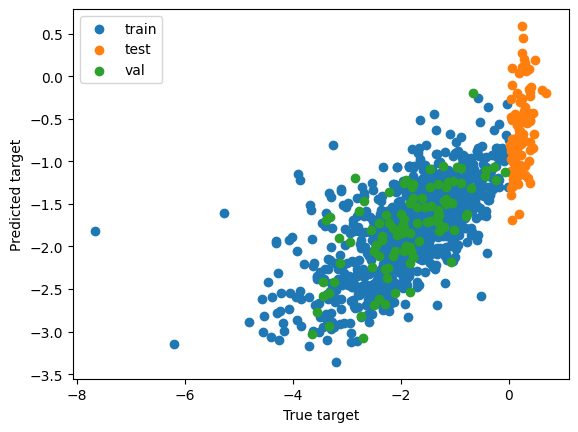

Training scores


In [ ]:
def get_prediction_results(df_element):
    with torch.no_grad():
        X_rpr = Representation.generate_repr(df_element)
        Y_pred = pymodel.graph_pred_linear(X_rpr).flatten(0).detach()
    return Y_pred

Y_pred_train = get_prediction_results(df_elements_train)
Y_pred_test = get_prediction_results(df_elements_test)
Y_pred_val = get_prediction_results(df_elements_val)

Y_train = df_train['target'].values
Y_test = df_test['target'].values
Y_val = df_val['target'].values

import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
ax.scatter(Y_train,Y_pred_train,label='train')  
ax.scatter(Y_test,Y_pred_test,label='test')
ax.scatter(Y_val,Y_pred_val,label='val')
ax.set_xlabel("True target")
ax.set_ylabel("Predicted target")
ax.legend()
plt.show()
# print training scores
print("Training scores")



In [ ]:
def get_scores(Y_pred,Y_true):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    mse = mean_squared_error(Y_true,Y_pred)
    mae = mean_absolute_error(Y_true,Y_pred)
    R2 = r2_score(Y_true,Y_pred)

    return mse,mae, R2
mse_train,mae_train, R2_train = get_scores(Y_pred_train,Y_train)
mse_test,mae_test, R2_test = get_scores(Y_pred_test,Y_test)
mse_val,mae_val, R2_val = get_scores(Y_pred_val,Y_val)
print(f"MSE train: {mse_train}, MAE train: {mae_train}, R2 train: {R2_train}")
print(f"MSE test: {mse_test}, MAE test: {mae_test}, R2 test: {R2_test}")
print(f"MSE val: {mse_val}, MAE val: {mae_val}, R2 val: {R2_val}")

MSE train: 0.47218486677324295, MAE train: 0.49575923257629434, R2 train: 0.4144995915717854
MSE test: 0.9505484314194328, MAE test: 0.889528400013436, R2 test: -48.33773331192871
MSE val: 0.35815809218622435, MAE val: 0.46623777603375216, R2 val: 0.44144960240674214
